# Choosing a baseline model
In this section we discuss what is usually the first stage in tackling an imbalanced classfication problem, namely, to choose a good enough baseline model so further modelling developments are to be compared with this **baseline** model. The discussion can be guided by the following driving questions:
* What is the effect of class imbalance on different classification algorithms?
* Is class imbalance really a problem when there is enough data?
* What is the best benchmark model to start with? What does "best" actually mean in this situation?
* What can be done to mitigate the effect of imbalance on specific algorithms?

## Methodology
We intend to study the behavior (in terms of binary classification metrics) of different classification algorithms under various imbalance scenarios.
At this point we won't pay too much attention on optimizing the model's parameters. Rather, we will work with the vanilla versions of the models as we are interested in finding a "quick" generic approach to solving an imbalanced binary classification problem. 

The classical algorithm used for solving a binary classification problem is the Logistic Regression (citation needed!), two types of regularization (L1 and L2) will be considered to see the effect of regularization in the imbalanced case. On the other hand, it is also common to use tree-based ensemble methods to construct a model for binary classification. Thus, it is natural to consider a couple of Tree ensemble algorithms, such as Random Forests and Gradient Boosting Machines for our experiments. 

Two datasets will be used for the experiments, namely, we will test the algorithms on a synthetic dataset and on a real dataset from which we can sample observations such that the class imbalance ratio can be changed at will. In the following lines we construct a function to generate the synthetic dataset and also load the *real-life* dataset.

In [1]:
# basics
import numpy as np
import pandas as pd
import seaborn as sns

from itertools import product
from typing import Any, List, Dict
from tqdm.auto import tqdm
# from tqdm.notebook import trange, tqdm

# plotting
import matplotlib
from matplotlib import pyplot as plt
# from matplotlib.animation import FuncAnimation


# sklearn
from sklearn.datasets import make_classification

## Data

### Synthetic Dataset (`make_classification`)
We will write a function that generates synthetic binary classification data allowing for various class imbalance levels


In [2]:
def create_imbalanced_binary_classification(n_samples: int = 1000, 
                                            n_features: int = 4,
                                            n_informative: int = None, 
                                            imbalance: float = 0.1,
                                            random_state: int = 42,
                                            class_sep : float = 1.0) -> pd.DataFrame:
    """Creates an imbalanced dataset for binary classification
    Parameters
    ----------
    n_samples: int, default = 1000,
            number of samples to generate
    n_features: int default = 4,
            number of features (not all are informative)
    n_informative: int default = None,
            number of informative features
            if none is specified floor(n_features/2) 
            will be taken
    imbalance: float, default = 0.1
            proportion of the minority class
    random_state: int, default = 42
    class_sep: float, default = 1.0
        The larger the value the easier the classification task
    Returns
    -------
    data: pd.DataFrame,
        dataframe with n_features + 1 columns
    """
    if n_informative == None:
        n_informative = int(n_features/2)
    weights = [1 - imbalance, imbalance]
    X, y = make_classification(n_samples = n_samples,
                                n_features = n_features,
                                n_classes=2,
                                n_informative = n_informative,
                                weights = weights,                
                                random_state = random_state,
                                class_sep = class_sep)
    column_names = [ f'feature_{i}' for i in np.arange(n_features)]      
    data = pd.concat([pd.DataFrame(X, columns = column_names), pd.DataFrame(y, columns = ['target'])], axis = 1)
    return data, column_names

Let us have a look at the dataset we have just created:

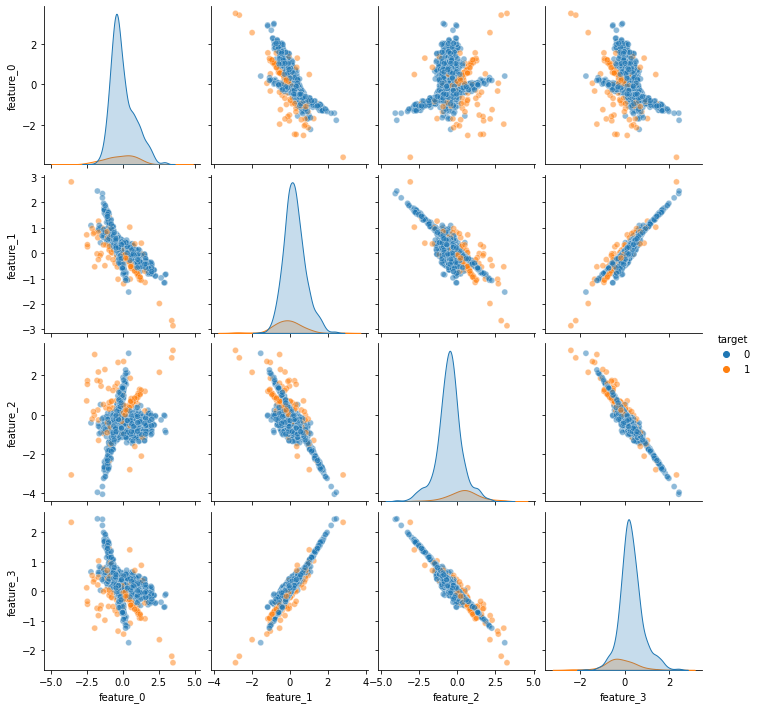

In [4]:
n_samples = 10**3
n_features = 4
imbalance = 0.1
n_informative = 2
class_sep = 0.5
data, column_names = create_imbalanced_binary_classification(n_samples = n_samples, 
                                        n_features = n_features,
                                        n_informative = n_informative,
                                        imbalance = imbalance,
                                        class_sep = class_sep)
sns.pairplot(data, hue = 'target', plot_kws = {'alpha' : 0.5})
plt.show()


### Real Life Datasets
In order to validate our experiments with synthetic data, let us collect a couple of *real-life* datasets. The first one is related to a classification taks that asks for predicting whether a subject's income exceeds $50K/yr based on census data. Also known as "Census Income" dataset.
The target is defined as whether the income is greater than $50k. The covariates are (mostly) categorical features related to census data. 

In [55]:
# Census-income dataset
census_df = pd.read_csv('../data/adult.data', header= None)

census_col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', \
                    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', \
                    'native-country']
census_df.columns = census_col_names + ['income']
# encode the target label
census_df['target'] = (census_df.income == ' >50K').astype(int)


In [56]:
census_df.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0


Clearly, we will need to pre-process the above dataset before we are able to actually use it for modelling purposes, to that intent we will use the usual sklearn's feature encoding utilities.

In [57]:
from sklearn.preprocessing import OneHotEncoder

In [61]:
census_categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
census_numerical_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


In [136]:
# One hot encoding of categorical features and join with numerical features
ohe = OneHotEncoder().fit(census_df[census_categorical_features])
census_ohe = pd.DataFrame(ohe.transform(census_df[census_categorical_features]).toarray(), columns = ohe.get_feature_names_out())
census_df_processed = census_df[census_numerical_features + ['target']].join(census_ohe)

The second dataset is related to a classification task that asks for predicting if an e-mail is spam or not, based on a very simple text encoding that counts the frequency of appearance of certain words in the e-mail text. 

In [105]:
spam_column_names = [
'classesword_freq_make',
'word_freq_address',   
'word_freq_all',      
'word_freq_3d',     
'word_freq_our',     
'word_freq_over',  
'word_freq_remove', 
'word_freq_internet',  
'word_freq_order',    
'word_freq_mail', 
'word_freq_receive',   
'word_freq_will',  
'word_freq_people',  
'word_freq_report',
'word_freq_addresses',
'word_freq_free',  
'word_freq_business',  
'word_freq_email',     
'word_freq_you',    
'word_freq_credit',    
'word_freq_your',     
'word_freq_font',     
'word_freq_000',    
'word_freq_money',     
'word_freq_hp',      
'word_freq_hpl',     
'word_freq_george',    
'word_freq_650',       
'word_freq_lab',    
'word_freq_labs',  
'word_freq_telnet',    
'word_freq_857',    
'word_freq_data',     
'word_freq_415',      
'word_freq_85',  
'word_freq_technology',
'word_freq_1999',
'word_freq_parts',
'word_freq_pm',        
'word_freq_direct',    
'word_freq_cs:',  
'word_freq_meeting',
'word_freq_original',  
'word_freq_project',   
'word_freq_re',        
'word_freq_edu',       
'word_freq_table',     
'word_freq_conference',
'char_freq_;',         
'char_freq_(',      
'char_freq_[',         
'char_freq_!',         
'char_freq_$',
'char_freq_#',
'capital_run_length_average', 
'capital_run_length_longest',
'capital_run_length_total',   
]

In [107]:
spam_df = pd.read_csv('../data/spambase.data', header = None)
spam_df.columns = spam_column_names + ['target']
spam_df.head()


,classesword_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,target
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


## Model comparison
In this section we will compare the performance (and other aspects) of different models under different class imbalance scenarios.
We will start by analyzing the performance dependence on the class imbalance index which we define as being the minority class ratio or *Prevalence*. If we call $N_{P}$ and $N_{N}$ the number of positive and negative observations, the prevalance is given by:
$$\nu := \dfrac{N_{P}}{N_{P}+N_{N}}.$$
The main parameter to be explored is $\nu$, going from an equal-class setup to a highly imbalanced scenario where there really few examples of the minority class.

The first simple analysis is to be made upon the performance impact of the imbalance in classes for several algorithms. At this point we are interested in answering a simple practical question:

<center><span style="background-color: gray">What is the best benchmark algorithm in the presence of class imbalance?</span></center>


To answer this question we might be interested in looking at other aspects of the statistical learning process aside of the classification performance metrics, such as: 
* Sample Size
* Fit Time
* Model complexity

In [115]:
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, matthews_corrcoef,  precision_recall_curve,\
                            average_precision_score, f1_score, auc


In [113]:
def bootstrap_samples(y_true: List, y_pred: List, n_batches: int = 100) -> List:
    """Get bootstrap samples

    Parameters
    ----------

    y_true : array_like, shape = [n_samples]
        true events labels

    y_pred : array_like, shape = [n_samples]
        events predictions

    n_batches : int, optinal
        number of bootstrap samples, default = 100

    Returns
    -------

    preds_samples : array_like, shape = [n_samples, [n_batches, 2]]
        list of bootstrap samples from y_true and y_preds
    """
    df_preds = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    n_samples = len(y_true)
    preds_samples = []
    for i in np.arange(n_batches):

        df_preds_resample = df_preds.sample(n_samples, replace=True)

        y_true_resample = df_preds_resample['y_true'].values
        y_pred_resample = df_preds_resample['y_pred'].values

        preds_samples.append({'y_true': y_true_resample,
                              'y_pred': y_pred_resample})

    preds_samples = preds_samples

    return preds_samples
    
def delinquency_curve(y_true, y_score, pointwise=True):
    """ Delinquency curve.

    The delinquency curve is curve that shows the default rate in function of
    the approval rate. With this curve is possible to have a clear view of a
    credit operation and its characteristics for all possible scenarios.

    Parameters
    ----------

    y_true : array, shape = [n_samples]
        Correct labels for given dataset.

    y_score : array, shape = [n_samples]
        Predict scores for the given dataset.

    pointwise : bool, optional
        boolean indicating whether to compute pointwise delinquency curve.

    Returns
    -------
    approval_rate: array, shape = [n_samples+1] if pointwise=True else [21]
        Array containing the approval rates used to compute the default_rate
        curve.
    default_rate: array, shape = [n_samples+1] if pointwise=True else [21]
        Default rate values for the approval rates provided in approval_rate.
        default_rate[i] is the ratio of events registered in the best
        approval_rate[i]% of scores.

    """
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    assert len(y_true) == len(y_score), F"y_true and y_score doesn't have " \
        F"the same length. len(y_true) = " \
        F"{len(y_true)}, len(y_score) = " \
        F"{len(y_score)}"

    indexsort = np.argsort(y_score)[::-1]
    y_approved = y_true[indexsort].copy()

    if pointwise:
        list_index = np.arange(1, len(y_approved)+1)
        approval_rate = np.append(0, list_index/len(list_index))
        default_rate = np.append(0, y_approved.cumsum()/list_index)
    else:
        approval_rate = np.linspace(0, 1, 21)
        n = len(y_true)

        default_rate = np.array([y_approved[:int(np.floor(i * n))].mean()
                                 if (y_approved[:int(np.floor(i * n))]
                                     .size)
                                 else 0 for i in approval_rate])
    return approval_rate, default_rate

In [114]:
def compute_metrics(y_true: List, y_proba: List, n_round: int = 2) -> pd.DataFrame:
    """Computes several classification metrics at once
    Parameters
    ----------
    y_true : array_like, shape = [n_samples]
        true events labels

    y_pred : array_like, shape = [n_samples]
        events predictions

    n_round : int, optional
        number o decimals to round gini and ks metrics
    Returns
    -------
    metrics: pd.DataFrame
    """
    metrics = {}
    # ROC AUC
    metrics['roc_auc'] = np.round(roc_auc_score(y_true, y_proba), n_round)
    # GINI
    metrics['gini'] = 2 * metrics['roc_auc'] - 1
    # Average precision
    metrics['avg_precision'] = np.round(average_precision_score(y_true, y_proba), n_round)
    # ROC Curve
    fpr, tpr, thresholds_roc = roc_curve(y_true = y_true, y_score = y_proba)
    metrics['roc_curve'] = {'fpr': fpr,
                            'tpr': tpr, 
                            'thresholds': thresholds_roc}
    # Precision-Recall curve
    precision, recall, thresholds_pr = precision_recall_curve(y_true = y_true, probas_pred = y_proba)
    metrics['pr_curve'] = {'precision' : precision,
                            'recall': recall,
                            'thresholds': thresholds_pr}
    # Delinquency curve
    d_curve_p = delinquency_curve(y_true = y_true, y_score = 1 - y_proba, pointwise= True)
    d_curve_agg = delinquency_curve(y_true = y_true, y_score = 1 - y_true, pointwise = False)
    metrics['d_curve_pointwise'] = d_curve_p
    metrics['d_curve_agg'] = d_curve_agg

    return metrics

def compute_metrics_bootstrap(y_true, y_pred, n_batches=100):
    """computes frequently used metrics from bootstramp samples

    Parameters
    ----------

    y_true : array_like, shape = [n_samples]
        true events labels

    y_pred : array_like, shape = [n_samples]
        events predictions

    n_batches : int, optinal
        number of bootstrap samples, default = 100

    Returns
    -------

    metrics_summary : dict
        dictionary containig statistics of gini, ks, d_curve and c_curves
    """
    preds_samples = bootstrap_samples(y_true, y_pred, n_batches)

    df_metrics = pd.DataFrame([compute_metrics(y['y_true'],
                                                     y['y_pred'])
                              for y in preds_samples])

    approval_rate_p = df_metrics['d_curve_pointwise'].iloc[0][0]
    default_rate_mean_p = df_metrics['d_curve_pointwise'].apply(
        lambda x: x[1]).mean()
    default_rate_std_p = df_metrics['d_curve_pointwise'].apply(
        lambda x: x[1]).values.std()
    d_curve_mean_p = (approval_rate_p, default_rate_mean_p)
    d_curve_std_p = (approval_rate_p, default_rate_std_p)

    approval_rate_agg = df_metrics['d_curve_agg'].iloc[0][0]
    default_rate_mean_agg = df_metrics['d_curve_agg'].apply(
        lambda x: x[1]).mean()
    default_rate_std_agg = df_metrics['d_curve_agg'].apply(
        lambda x: x[1]).values.std()
    d_curve_mean_agg = (approval_rate_agg, default_rate_mean_agg)
    d_curve_std_agg = (approval_rate_agg, default_rate_std_agg)

    metrics_stats = df_metrics[['roc_auc',
                                'gini',
                                'avg_precision',
                                # 'ks'
                                ]].apply([np.mean, np.std])

    metrics_summary = {'d_curve_pointwise': {'d_curve_mean': d_curve_mean_p,
                                             'd_curve_std': d_curve_std_p},
                       'd_curve_agg': {'d_curve_mean': d_curve_mean_agg,
                                       'd_curve_std': d_curve_std_agg},
                       'metrics_stats': metrics_stats,
                       'df_metrics': df_metrics}
    return metrics_summary

In [123]:
n_samples = 10**4
n_features = 6
n_informative = 3
class_sep = 0.5
metrics = {}
fit_time = {}
imbalances = [0.5, 0.2, 0.1, 0.05, 0.01, 5e-3, 1e-3, 5e-4]
random_state = 42
for imbalance in tqdm(imbalances):
    print(f'Minority class proportion: {imbalance}')
    metrics[imbalance] = {}
    # Create dataset
    data, column_names = create_imbalanced_binary_classification(n_samples = n_samples, 
                                        n_features = n_features,
                                        n_informative = n_informative,
                                        imbalance = imbalance,
                                        class_sep = class_sep)
    # Train test split (Stratified)
    X, y = data[column_names], data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, stratify = y)
    
    # Logistic Regression L2
    print('\tLog Regression L2 ...')
    lr_pipeline = Pipeline([('scaler', StandardScaler()),
                            ('logreg', LogisticRegression())])
    lr_pipeline.fit(X_train, y_train)
    y_proba_lr = lr_pipeline.predict_proba(X_test)
    metrics[imbalance]['logreg_l2'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_lr[:,1])
    
    # Logistic Regression L1
    print('\tLog Regression L1 ...')
    lr_pipeline_2 = Pipeline([('scaler', StandardScaler()),
                            ('logreg', LogisticRegression(penalty= 'l1', solver = 'saga'))])
    lr_pipeline_2.fit(X_train, y_train)
    y_proba_lr_2 = lr_pipeline_2.predict_proba(X_test)
    metrics[imbalance]['logreg_l1'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_lr_2[:,1])
    

    # Random Forest
    print('\tRandom Forest ...')
    rf_clf = RandomForestClassifier()
    rf_clf.fit(X_train, y_train)
    y_proba_rf = rf_clf.predict_proba(X_test)
    metrics[imbalance]['rf'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_rf[:,1])

    # Gradient Boosting Machine
    print('\tGradient Boosting ...')
    gb_clf = HistGradientBoostingClassifier()
    gb_clf.fit(X_train, y_train)
    y_proba_gb = gb_clf.predict_proba(X_test)
    metrics[imbalance]['gb'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_gb[:,1])

    # Dummy Classifier
    print('\tDummy Classifier ...')
    dummy_clf = DummyClassifier()
    dummy_clf.fit(X_train, y_train)
    y_proba_dummy = dummy_clf.predict_proba(X_test)
    metrics[imbalance]['dummy'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_dummy[:,1])

print('end')

  0%|          | 0/8 [00:00<?, ?it/s]

Minority class proportion: 0.5
	Log Regression L2 ...
	Log Regression L1 ...


/Users/c85538a/anaconda3/envs/ibc/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


	Random Forest ...
	Gradient Boosting ...
	Dummy Classifier ...
Minority class proportion: 0.2
	Log Regression L2 ...
	Log Regression L1 ...


/Users/c85538a/anaconda3/envs/ibc/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


	Random Forest ...
	Gradient Boosting ...
	Dummy Classifier ...
Minority class proportion: 0.1
	Log Regression L2 ...
	Log Regression L1 ...


/Users/c85538a/anaconda3/envs/ibc/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


	Random Forest ...
	Gradient Boosting ...
	Dummy Classifier ...
Minority class proportion: 0.05
	Log Regression L2 ...
	Log Regression L1 ...


/Users/c85538a/anaconda3/envs/ibc/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


	Random Forest ...
	Gradient Boosting ...
	Dummy Classifier ...
Minority class proportion: 0.01
	Log Regression L2 ...
	Log Regression L1 ...


/Users/c85538a/anaconda3/envs/ibc/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


	Random Forest ...
	Gradient Boosting ...
	Dummy Classifier ...
Minority class proportion: 0.005
	Log Regression L2 ...
	Log Regression L1 ...


/Users/c85538a/anaconda3/envs/ibc/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


	Random Forest ...
	Gradient Boosting ...
	Dummy Classifier ...
Minority class proportion: 0.001
	Log Regression L2 ...
	Log Regression L1 ...


/Users/c85538a/anaconda3/envs/ibc/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


	Random Forest ...
	Gradient Boosting ...
	Dummy Classifier ...
Minority class proportion: 0.0005
	Log Regression L2 ...
	Log Regression L1 ...


/Users/c85538a/anaconda3/envs/ibc/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


	Random Forest ...
	Gradient Boosting ...
	Dummy Classifier ...
end


In [126]:
def plot_metric_evolution(metrics: Dict, 
                          model_name: str,
                          metric_4_display: str = 'roc_auc',
                          color: str = 'purple', 
                          ax: matplotlib.axis = None) -> matplotlib.axis:
    """
    Plots the imbalance-evolution of classification metrics

    """
    labels = {'logreg_l2': 'Logistic Regression L2',
              'logreg_l1': 'Logistic Regression L1',
              'rf': 'Random Forest',
              'gb': 'Gradient Boosting',
              'dummy': 'Dummy Classifier' }
    if ax == None:
        f, ax = plt.subplots(dpi = 100)
    metrics_mean = [metrics[x][model_name]['metrics_stats'][metric_4_display]['mean'] for x in metrics.keys()]
    metrics_std = [metrics[x][model_name]['metrics_stats'][metric_4_display]['std'] for x in metrics.keys()]
    x = range(len(metrics.keys()))
    ax.plot(metrics_mean, marker = '.', linestyle = '--',
            color = color, label = labels[model_name],
            alpha = 0.6)
    ax.fill_between(x = x, 
                    y1 = np.subtract(metrics_mean, metrics_std), 
                    y2 =np.add(metrics_mean, metrics_std),
                    alpha = 0.2, facecolor = color)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics.keys())
    ax.set_xlabel('Minority class proportion')
    return ax

def clean_ax(ax, all = False):
    """Clean spines of a matplotlib axis"""
    if all:
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)    
    ax.spines["top"].set_visible(False)
    return ax

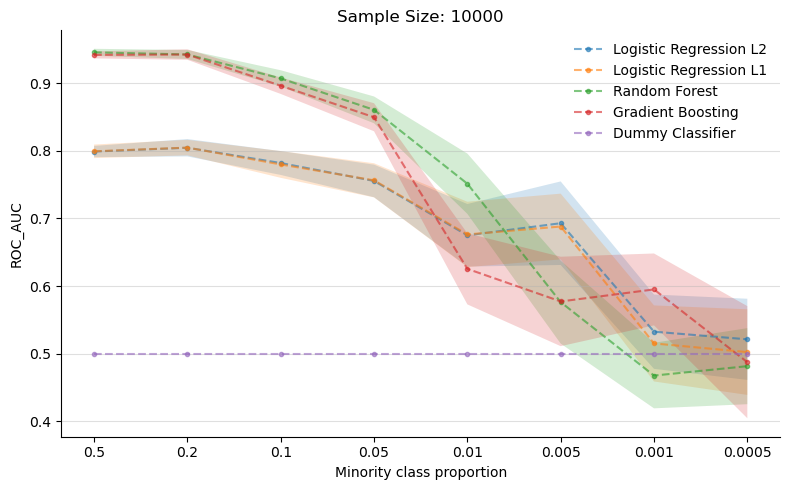

In [131]:
metric_4_display = 'roc_auc'
colors = {'logreg_l2': 'C0',
          'logreg_l1': 'C1',
          'rf': 'C2',
          'gb': 'C3',
          'dummy': 'C4'}
f, ax = plt.subplots(dpi = 100, figsize = (8,5))
for model_name, color in colors.items():
    plot_metric_evolution(metrics, model_name, metric_4_display= metric_4_display, color = color, ax = ax)
ax.legend(loc = 'best', frameon = False)
ax.grid(True, axis = 'y', alpha = 0.4)
ax.set_ylabel(metric_4_display.upper())
ax.set_title(f'Sample Size: {n_samples}')
clean_ax(ax)
f.tight_layout()

In [172]:
def undersample(X, y, d, random_state=42):
    """
    Constructs a dataset by undersampling the positive class given a certain 
    imbalance ratio

    Parameters
    ----------
    X: pd.DataFrame
    y: pd.Series
    d: float 
        desired imbalance ratio
    random_state: int (default = 42)

    Returns
    -------
    X, y with the desired imbalance ratio
    """
    alpha = - d/(d-1)
    size = int((y==0).sum()*alpha)
    try:
        return (
            np.vstack([X[y==0], pd.DataFrame(X[y==1]).sample(n=size, replace=False, random_state=random_state)]),
            np.hstack([y[y==0], np.array(size*[1])])
        )
    except:
        return X, y

In [169]:
census_feature_names = list(set(census_df_processed.columns).difference(set('target')))
X, y = undersample(census_df_processed[census_feature_names], census_df_processed['target'], d = 0.1)



In [171]:
census_df_processed['target'].mean()

0.2408095574460244

In [159]:
alpha = 0.24/0.75

In [160]:
alpha

0.32